# Tier 2. Module 6 - Data Engineering. Homework

## Lesson 04. Apache Spark. Optimization and SparkUI

Your task is to execute several variants of the same/similar code and think about the appearance of SparkUI. You need to:

* run three programs;
* take screenshots of three sets of Jobs;
* analyze and be able to justify the presence of a certain number of Jobs in each set;
* understand what the cache function does and why it is used.

The [link](https://drive.google.com/file/d/1XmmUpuTwNH6YZHZMVRYQe0vJvBy3vQY5/view?usp=sharing) to the necessary data.

### Technical Task

#### Part 1
Let's take the code you're already familiar with and add an intermediate action:

In [2]:
from pyspark.sql import SparkSession

# Creating a Spark session
spark = (
    SparkSession.builder.master("local[*]")
    .config("spark.sql.shuffle.partitions", "2")
    .appName("MyGoitSparkSandbox")
    .getOrCreate()
)

# Loading the dataset
nuek_df = (
    spark.read.option("header", "true")
    .option("inferSchema", "true")
    .csv("./nuek-vuh3.csv")
)

nuek_repart = nuek_df.repartition(2)

nuek_processed = (
    nuek_repart.where("final_priority < 3")
    .select("unit_id", "final_priority")
    .groupBy("unit_id")
    .count()
)

# Here is the line added HERE
nuek_processed = nuek_processed.where("count>2")

nuek_processed.collect()

input("Press Enter to continue...5")

# Closing the Spark session
spark.stop()

your 131072x1 screen size is bogus. expect trouble
25/03/23 13:04:46 WARN Utils: Your hostname, MatajurPC resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
25/03/23 13:04:46 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/03/23 13:04:46 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Run the code. Take a screenshot of all Jobs (there should be 5 of them).

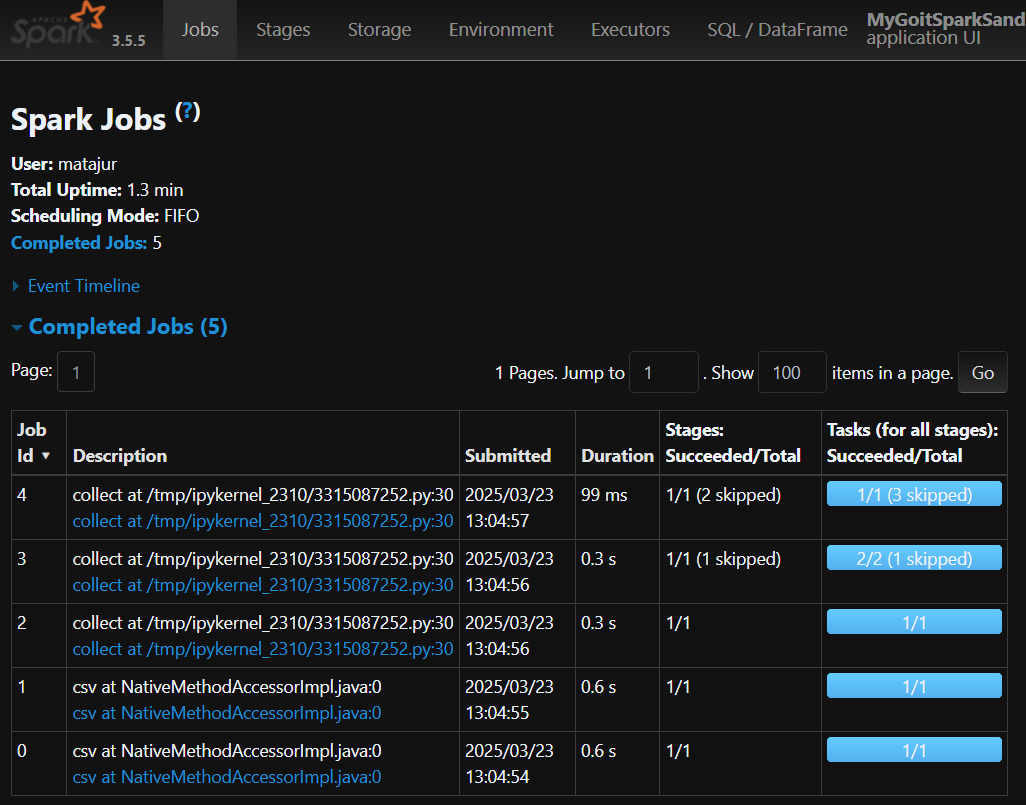

The jobs:
- Job 0 - Read CSV (I/O);
- Job 1 - Repartition (Shuffler) of data across 2 partitions;
- Job 2 - Filter + Select (Optimization barrier);
- Job 3 - GroupBy (Shuffler) + Count;
- Job 4 - Filter on Count + Collect (Action).

#### Part 2
Add an intermediate Action — `collect`:

In [4]:
from pyspark.sql import SparkSession

# Creating a Spark session
spark = (
    SparkSession.builder.master("local[*]")
    .config("spark.sql.shuffle.partitions", "2")
    .appName("MyGoitSparkSandbox")
    .getOrCreate()
)

# Loading the dataset
nuek_df = (
    spark.read.option("header", "true")
    .option("inferSchema", "true")
    .csv("./nuek-vuh3.csv")
)

nuek_repart = nuek_df.repartition(2)

nuek_processed = (
    nuek_repart.where("final_priority < 3")
    .select("unit_id", "final_priority")
    .groupBy("unit_id")
    .count()
)

# Intermediate action: collect
nuek_processed.collect()

# Here is the line added HERE
nuek_processed = nuek_processed.where("count>2")

nuek_processed.collect()

input("Press Enter to continue...5")

# Closing the Spark session
spark.stop()

Run the code. Take a screenshot of all Jobs (there should be 8 of them).

🧠 Think about why, when adding one intermediate action `nuek_processed.collect()`, we get 3 more Jobs?

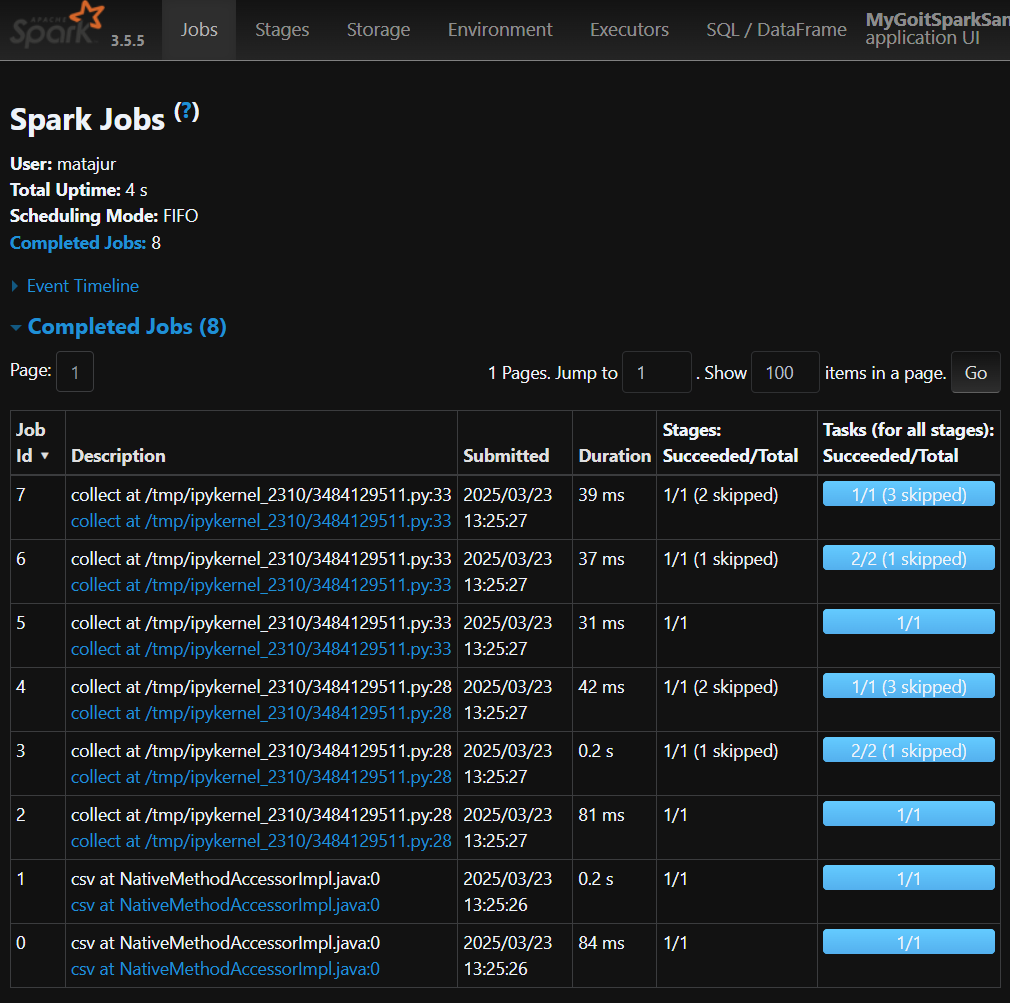

The jobs:
- Job 0 - Read CSV (I/O);
- Job 1 - Repartition (Shuffler) of data across 2 partitions;
- Job 2 - Filter + Select (Optimization barrier);
- Job 3 - GroupBy (Shuffler) + Count;
- Job 4 - Collect (Action);
- Job 5 - Filter + Select (Optimization barrier);
- Job 6 - GroupBy (Shuffler) + Count;
- Job 7 - Filter on Count + Collect (Action).

Since `nuek_processed` was not cached before the `collect` action was triggered the first time, Spark has to recalculate it from scratch to execute the second `collect` action, using already uploaded and partitioned dataframe.

#### Part 3
We will use the new `cache` function in the intermediate result.

In [7]:
from pyspark.sql import SparkSession

# Creating a Spark session
spark = (
    SparkSession.builder.master("local[*]")
    .config("spark.sql.shuffle.partitions", "2")
    .appName("MyGoitSparkSandbox")
    .getOrCreate()
)

# Loading the dataset
nuek_df = (
    spark.read.option("header", "true")
    .option("inferSchema", "true")
    .csv("./nuek-vuh3.csv")
)

nuek_repart = nuek_df.repartition(2)

nuek_processed_cached = (
    nuek_repart.where("final_priority < 3")
    .select("unit_id", "final_priority")
    .groupBy("unit_id")
    .count()
    .cache()
)  # Added cache function

# Intermediate action: collect
nuek_processed_cached.collect()

# Here is the line added HERE
nuek_processed = nuek_processed_cached.where("count>2")

nuek_processed.collect()

input("Press Enter to continue...5")

# Freeing memory from the Dataframe
nuek_processed_cached.unpersist()

# Closing the Spark session
spark.stop()

Run the code. Take a screenshot of all Jobs (there should be 7 of them).

🧠Think about why we reduced the number of Jobs when using `cache()`?

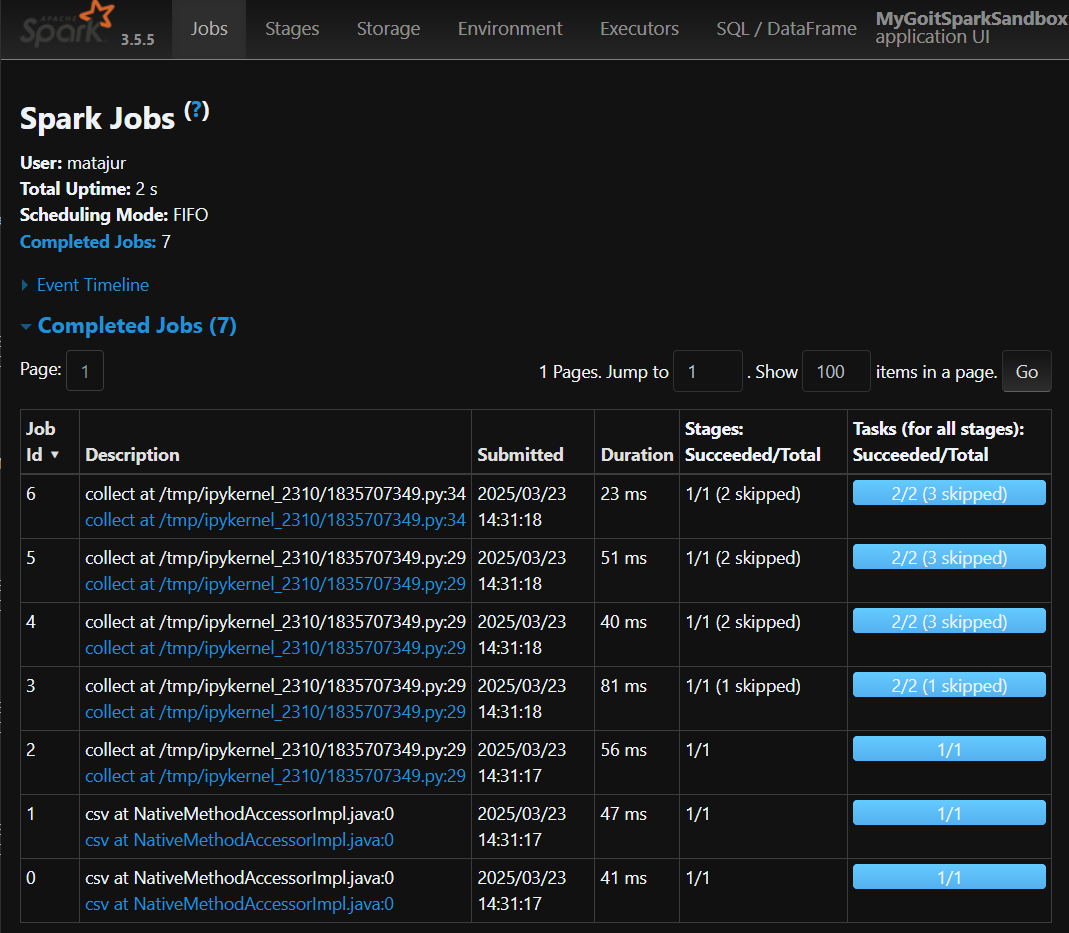

The jobs:
- Job 0 - Read CSV (I/O);
- Job 1 - Repartition (Shuffler) of data across 2 partitions;
- Job 2 - Filter + Select (Optimization barrier);
- Job 3 - GroupBy (Shuffler) + Count;
- Job 4 - Materialize Cache;
- Job 5 - Collect (Action);
- Job 6 - Filter on cached data + Collect (Action).

This time there is one less job because caching `nuek_processed` requires one additional job, but replaces two jobs with previously performed dataframe transformations.